## SIS on Beer Reviews - Model Training Aspect 1 (Aroma)

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import sys
import gzip
sys.path.insert(0, os.path.abspath('..'))

from keras.callbacks import ModelCheckpoint
from keras.models import load_model, Model, Sequential
from keras.layers import Input, Dense, Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.preprocessing import sequence, text
from keras import backend as K
from sklearn.model_selection import train_test_split

In [4]:
import os
import tensorflow as tf

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

sess = tf.Session(config=config)

K.set_session(sess)

In [5]:
def load_reviews(path, verbose=True):
    data_x, data_y = [ ], [ ]
    fopen = gzip.open if path.endswith(".gz") else open
    with fopen(path) as fin:
        for line in fin:
            line = line.decode('ascii')
            y, sep, x = line.partition("\t")
            # x = x.split()
            y = y.split()
            if len(x) == 0: continue
            y = np.asarray([ float(v) for v in y ])
            data_x.append(x)
            data_y.append(y)

    if verbose:
        print("{} examples loaded from {}".format(len(data_x), path))
        print("max text length: {}".format(max(len(x) for x in data_x)))

    return data_x, data_y

In [11]:
# Load beer review data for a particular aspect

ASPECT = 1  # 1, 2, or 3

BASE_PATH = '../data/beer_reviews'

path = os.path.join(BASE_PATH, 'reviews.aspect' + str(ASPECT))
train_path = path + '.train.txt.gz'
heldout_path = path + '.heldout.txt.gz'

X_train_texts, y_train = load_reviews(train_path)
X_test_texts, y_test = load_reviews(heldout_path)

# y value is just the sentiment for this aspect, throw away the other scores
y_train = np.array([y[ASPECT] for y in y_train])
y_test = np.array([y[ASPECT] for y in y_test])

# Create a 3k validation set held-out from the test set
X_test_texts, X_val_texts, y_test, y_val = train_test_split(
                                                X_test_texts,
                                                y_test,
                                                test_size=3000,
                                                random_state=42)

70000 examples loaded from ../data/beer_reviews/reviews.aspect1.train.txt.gz
max text length: 5085
10000 examples loaded from ../data/beer_reviews/reviews.aspect1.heldout.txt.gz
max text length: 4619


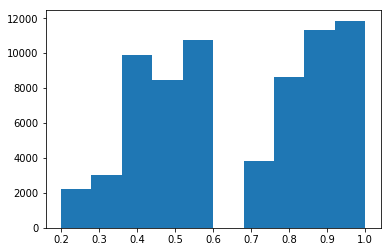

Mean: 0.680
Median: 0.700
Stdev: 0.238
Review length:
Mean 154.47 words (stddev: 81.134751)


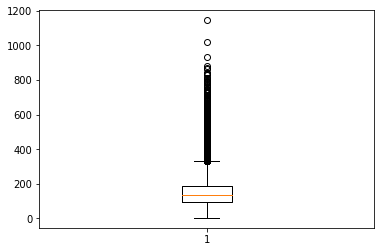

In [7]:
plt.hist(y_train)
plt.show()

print('Mean: %.3f' % np.mean(y_train))
print('Median: %.3f' % np.median(y_train))
print('Stdev: %.3f' % np.std(y_train))

print('Review length:')
train_texts_lengths = [len(x.split(' ')) for x in X_train_texts]
print("Mean %.2f words (stddev: %f)" % \
      (np.mean(train_texts_lengths),
       np.std(train_texts_lengths)))

# plot review lengths
plt.boxplot(train_texts_lengths)
plt.show()

In [8]:
# Tokenize the texts and keep only the top n words

TOP_WORDS = 10000

tokenizer = text.Tokenizer(num_words=TOP_WORDS)

tokenizer.fit_on_texts(X_train_texts)

X_train = tokenizer.texts_to_sequences(X_train_texts)
X_val = tokenizer.texts_to_sequences(X_val_texts)
X_test = tokenizer.texts_to_sequences(X_test_texts)

print(len(X_train))
print(len(X_val))
print(len(X_test))

70000
3000
7000


In [9]:
# Bound reviews at 500 words, truncating longer reviews and zero-padding shorter reviews

MAX_WORDS = 500

X_train = sequence.pad_sequences(X_train, maxlen=MAX_WORDS)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_WORDS)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_WORDS)

In [10]:
index_to_token = {tokenizer.word_index[k]: k for k in tokenizer.word_index.keys()}

## LSTM Model

In [9]:
def coeff_determination_metric(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [12]:
# LSTM 200
def make_lstm_model(top_words, max_words):
    model = Sequential()
    model.add(Embedding(top_words, 100, input_length=max_words))
    model.add(LSTM(200, return_sequences=True))
    model.add(LSTM(200))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse',
                  optimizer=Adam(),
                  metrics=['mse', 'mae', coeff_determination_metric])
    return model

model = make_lstm_model(TOP_WORDS, MAX_WORDS)
print(model.summary())

checkpointer = ModelCheckpoint(filepath='../trained_models/asp1.regress.bs128.nodrop.lstm200.100dimembed.weights.{epoch:02d}-{val_loss:.4f}.hdf5',
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=15,
          batch_size=128,
          callbacks=[checkpointer],
          verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 200)          240800    
_________________________________________________________________
lstm_6 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 1,561,801
Trainable params: 1,561,801
Non-trainable params: 0
_________________________________________________________________
None
Train on 70000 samples, validate on 3000 samples
Epoch 1/15
69888/70000 [============================>.] - ETA: 1s - loss: 0.0472 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1838 - coeff_determination_metric: 0.1582
Epoch 00001: val_loss improved fr